# Jupyter notebook to plot the saved results

## Importing required header files

In [22]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('../../../FinRL/')
sys.path.append("../FinRL-Library")

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint
import itertools
import warnings
warnings.filterwarnings("ignore")


In [25]:
seed = 2
window_size = 63
retrain_window = 63
tr_s_date = '2009-04-01'
tr_e_date = '2021-01-01'
te_s_date = '2021-01-01'
te_e_date = '2022-06-01'
use_extra_features = False
reward_type = "Sharpe"
result_path = 'results/overnight_run'
file_name = "{}/{}_{}_{}_{}_{}.csv".format(result_path,reward_type,window_size,retrain_window,use_extra_features, seed)
file = pd.read_csv(file_name)
df_account_value = file.copy()


In [26]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Backtest Results===========
Annual return         -0.013224
Cumulative returns    -0.013224
Annual volatility      0.140768
Sharpe ratio          -0.024698
Calmar ratio          -0.088583
Stability              0.053835
Max drawdown          -0.149282
Omega ratio            0.995761
Sortino ratio         -0.033854
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.958655
Daily value at risk   -0.017749
dtype: float64
==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)
Annual return          0.037486
Cumulative returns     0.037335
Annual volatility      0.134331
Sharpe ratio           0.342028
Calmar ratio           0.331049
Stability              0.066383
Max drawdown          -0.113235
Omega ratio            1.058031
Sortino ratio          0.480831
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.970

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (251, 8)


Start date,2021-04-06
End date,2022-04-01
Total months,12
,Backtest
Annual return,10.9%
Cumulative returns,10.9%
Annual volatility,14.0%
Sharpe ratio,0.81
Calmar ratio,1.25
Stability,0.60
Max drawdown,-8.7%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.69,2022-01-04,2022-03-08,NaT,NaN
1,6.85,2021-11-15,2021-12-01,2021-12-27,31
2,5.27,2021-09-01,2021-09-21,2021-10-15,33
3,4.20,2021-07-12,2021-07-19,2021-08-06,20
4,2.52,2021-05-07,2021-05-12,2021-05-24,12


Stress Events,mean,min,max
New Normal,0.04%,-4.04%,4.23%


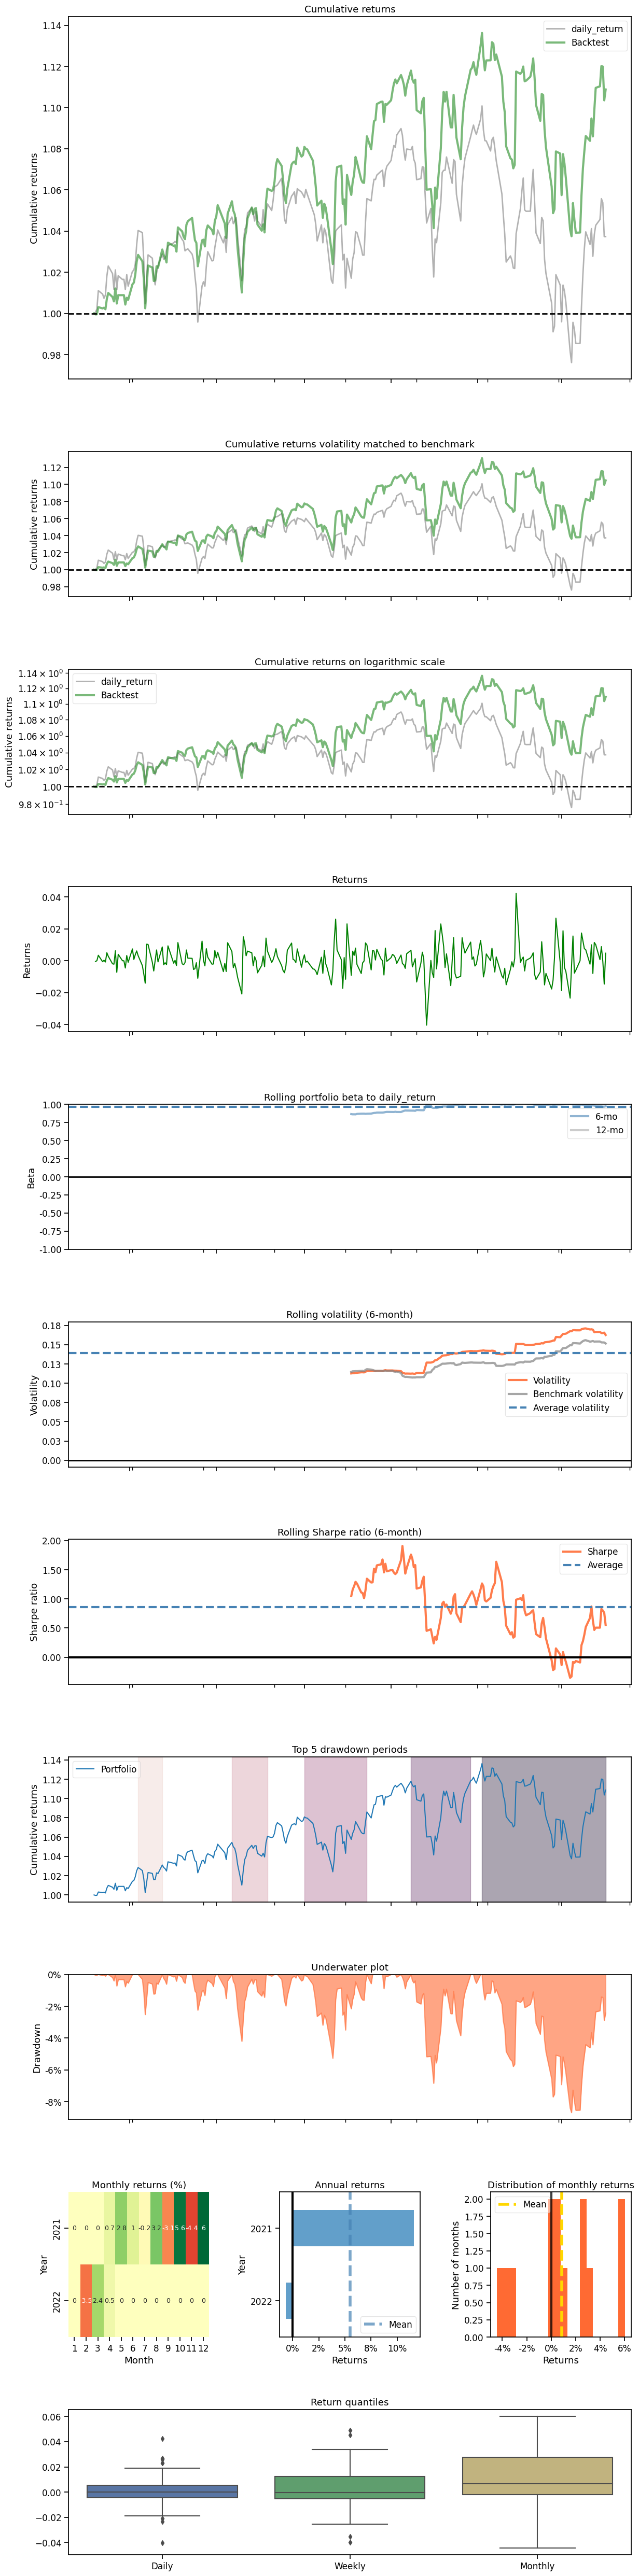

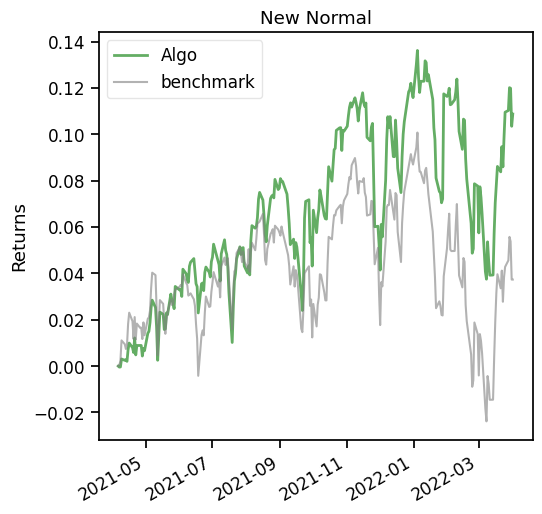

In [30]:

seed = 0
window_size = 63
retrain_window = 63
tr_s_date = '2009-04-01'
tr_e_date = '2021-01-01'
te_s_date = '2021-01-01'
te_e_date = '2022-06-01'
use_extra_features = True
reward_type = "Profit"
result_path = 'results/overnight_run'
file_name = "{}/{}_{}_{}_{}_{}.csv".format(result_path,reward_type,window_size,retrain_window,use_extra_features, seed)
file = pd.read_csv(file_name)
df_account_value = file.copy()


%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])

In [31]:
df_account_value.columns

Index(['Unnamed: 0', 'account_value', 'date', 'daily_return', 'datadate'], dtype='object')

In [142]:
seeds = [0,1,2]
window_size = 63
# retrain_window = 21
tr_s_date = '2009-04-01'
tr_e_date = '2021-01-01'
te_s_date = '2021-01-01'
te_e_date = '2022-06-01'
use_extra_features = True
reward_type = "Sharpe"
result_path = 'results/overnight_run'
dfs = []
for seed in seeds:
    file_name = "{}/{}_{}_{}_{}_{}.csv".format(result_path,reward_type,window_size,window_size,use_extra_features, seed)
    file = pd.read_csv(file_name)
    dfs.append(file.copy())

# df_account_value = file.copy()


Text(0.5, 1.0, 'Fraction account value, run with Sharpe as metric over 3 seeds with window size 63')

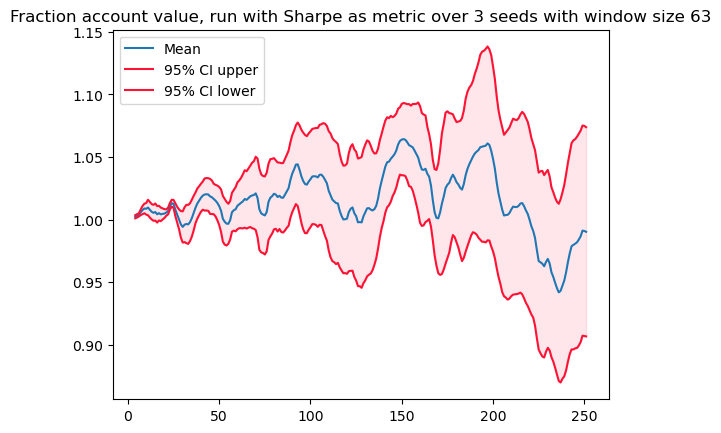

In [143]:
# df_array = dfs
# dfs = []
# for df in df_array:
#         dfs.append(df.account_value)
# df_all = pd.concat(dfs, axis=1)
# df_all.head()
# dfs[0].head()
window = 5
dates = dfs[0].date
account_list = []
for df in dfs:
    assert dates.compare(df['date']).empty # Making sure the dates/periods are the same
    account_list.append(df['account_value']/1e6)
all_accounts = pd.concat(account_list, axis = 1)
new_columns = ["seed_"]*len(seeds)
new_columns = [new_columns[i]+str(seeds[i]) for i in range(len(new_columns))]
all_accounts.columns = new_columns
# all_accounts.head(10)
all_accounts['mean'] = all_accounts.mean(axis = 1)
all_accounts['std_dev'] = all_accounts.std(axis = 1)
all_accounts['max_val'] = all_accounts['mean'] + 2*all_accounts['std_dev']
all_accounts['min_val'] = all_accounts['mean'] - 2*all_accounts['std_dev']
all_accounts['rolling_mean'] =  all_accounts['mean'].rolling(window).mean()
all_accounts['rolling_std_dev'] =  all_accounts['std_dev'].rolling(window).mean()
all_accounts['rolling_max_val'] = all_accounts['rolling_mean'] + 2*all_accounts['rolling_std_dev']
all_accounts['rolling_min_val'] = all_accounts['rolling_mean'] - 2*all_accounts['rolling_std_dev']
# for col in new_columns:
#     plt.plot(all_accounts.index,all_accounts[col])
# plt.plot(all_accounts.index,all_accounts['mean'])
# plt.plot(all_accounts.index,all_accounts['min_val'],'b')
# plt.plot(all_accounts.index,all_accounts['max_val'],'b')
plt.fill_between
plt.plot(all_accounts.index,all_accounts['rolling_mean'],label = "Mean")
plt.plot(all_accounts.index,all_accounts['rolling_min_val'],'#FF1234', label = "95% CI upper")
plt.plot(all_accounts.index,all_accounts['rolling_max_val'],'#FF1234', label = "95% CI lower")
plt.fill_between(all_accounts.index, all_accounts['rolling_max_val'], all_accounts['rolling_min_val'], color='#FF1234',alpha=0.1)
plt.legend(loc="upper left")
if(use_extra_features == True):
    plt.title("Fraction account value, run with {} as metric over {} seeds with window size {} and extra features".format(reward_type,len(seeds),window_size))
    
else:
    plt.title("Fraction account value, run with {} as metric over {} seeds with window size {}".format(reward_type,len(seeds),window_size))

# all_accounts.head(20)



In [ ]:
def plot_multiple_seeds(df_array, window = 10):
    dfs = []
    for df in df_array:
        dfs.append(df.account_value)
    df_all = pd.concat(dfs, ignore_index=True)
    # compute rolling means and confident intervals
    mean_val = df_all.rolling(window).mean()
    std_val = df_all.rolling(window).std()
    min_val = mean_val - 2*std_val
    max_val = mean_val + 2*std_val
    
    plt.figure(figsize=(16,9))
    for df in dfs:
        plt.plot(df, c='blue')

    # plt.plot(mean_val, c='r')
    # plt.fill_between(df_all.min_val, max_val, color='blue', alpha=.2)
    plt.show()

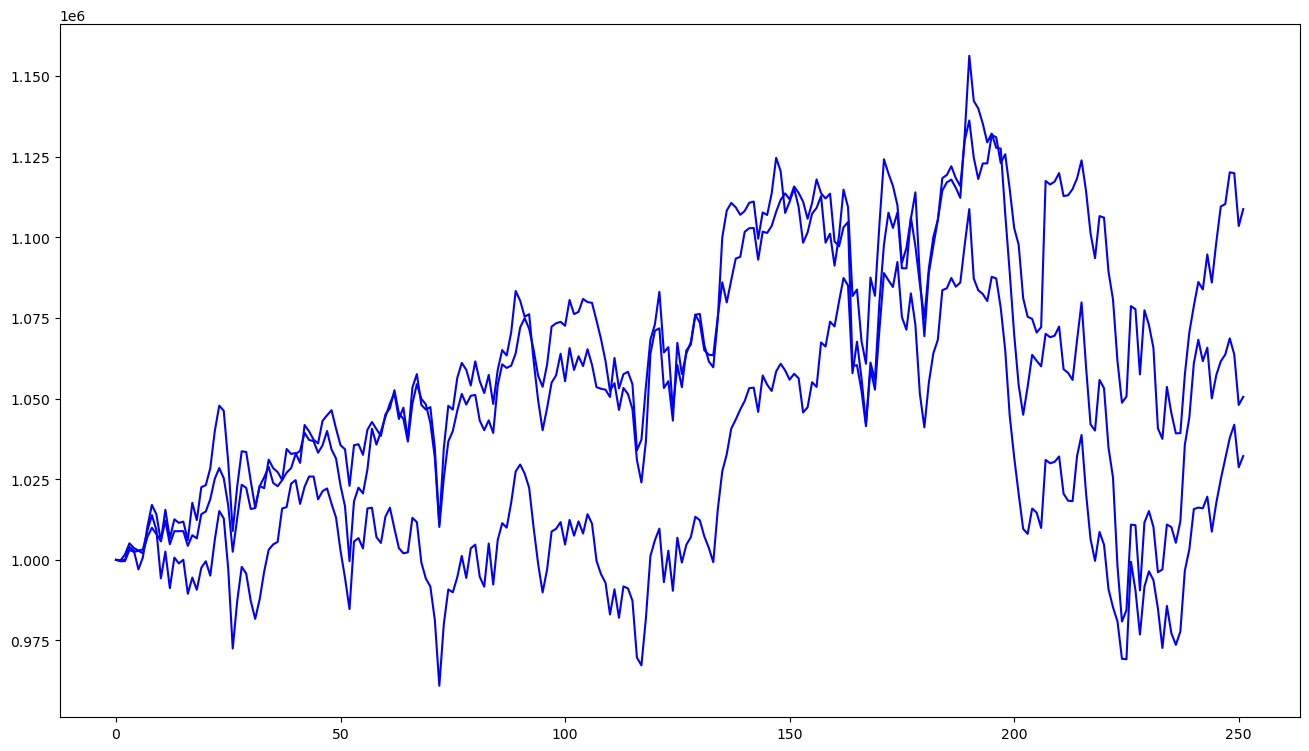

In [51]:
plot_multiple_seeds(dfs)

In [ ]:
# backtest_stats(df_account_value, value_col_name = 'account_value')
df_account_value.account_value.plot()
p = baseline_df.close*1000000/33430.238281
p.plot()